# **Imports and settings**

In [0]:
import os
from shutil import copyfile
from shutil import rmtree
import logging
import json
import math
from datetime import datetime

from more_itertools import sliced
from random import randint
from random import choices
import random
from google.cloud import storage

import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
import numpy as np
import seaborn as sn
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


logging.basicConfig(filename="tracker.log", level=logging.DEBUG, filemode="w")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "activitytracker-bde5c-firebase-adminsdk-ks82x-ad642b2476.json"
client = storage.Client()


# **Data Types**

In [0]:
class Motion:
    def __init__(self, name: str, tag: str):
        self.name = name
        self.tag = tag


class Data:
    def __init__(self, dict_json: dict):
        self.fileName = dict_json['fileName']
        self.motion = dict_json['motion']
        self.time = dict_json['time']
        self.userName = dict_json['userName']
        self.listX = []
        self.listY = []
        self.listZ = []
        
        for idx, val in enumerate(dict_json['graphList']):
            if idx % 3 == 0:
                self.listX.append(val)
            if idx % 3 == 1:
                self.listY.append(val)
            if idx % 3 == 2:
                self.listZ.append(val)

    def __str__(self):
        return self.fileName

class ParsedData:
    def __init__(self, dict_json: dict):
        self.fileName = dict_json['fileName']
        self.motion = dict_json['motion']
        self.time = dict_json['time']
        self.userName = dict_json['userName']
        self.listX = dict_json['listX']
        self.listY = dict_json['listY']
        self.listZ = dict_json['listZ']

    def __str__(self):
        return self.fileName     
      
class CroppedData:
    def __init__(self, file_name, motion, time, user_name, list_x, list_y, list_z):
        self.fileName = file_name
        self.motion = motion
        self.time = time
        self.userName = user_name
        self.listX = list_x
        self.listY = list_y
        self.listZ = list_z
        
    def __str__(self):
        return self.fileName

class MarkedData:
    def __init__(self, file_name, motion, time, user_name, list_x, list_y, list_z, steps):
        self.fileName = file_name
        self.motion = motion
        self.time = time
        self.userName = user_name
        self.listX = list_x
        self.listY = list_y
        self.listZ = list_z
        self.steps = steps
        
    def __str__(self):
        return self.fileName

# **Create directories and file list**

In [0]:
def create_folder(folder: str):
  if not os.path.exists(folder):
    os.makedirs(folder)
    logging.debug(f"A directory {folder} has been created.")

    
def create_folders(folders: list):
  for folder in folders:
    create_folder(folder)
    

def list_local_files(folder: str) -> list:
  files = [f"{folder}/" + file for file in os.listdir(folder)]
  random.shuffle(files)
  return files

# **FireBase**

In [0]:
def get_blobs(bucket_name: str, blob_prefix: str = None, delimiter: str = None) -> list:
    """
    This function returns a list of all files in FireBase. This will be needed to download files.
    :param bucket_name: This is the name of the repository with such ending appspot.com
    :param blob_prefix: Directory Name
    :param delimiter: No, you’ll understand it yourself. This is a separator
    :return: List<Blob> with fields for each blob: name, id, bucket_name
    """

    bucket = client.get_bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=blob_prefix, delimiter=delimiter)
    return [blob for blob in blobs]


def download_blobs(blobs: list, folder: str):
    """
    This function downloads each blob from the blobs list to the specified directory.
    :param blobs: List of storage.Blob
    :param folder: Path to save blobs(json)
    :return: None
    """

    create_folder(folder)

    for blob in blobs:
        destination_uri = f"{folder}/{blob.name.split('/')[1]}"
        blob.download_to_filename(destination_uri)
        logging.debug(f"The file ({blob.name}) has been downloaded to the {folder}.")


def upload_blob(bucket_name: str, file_path, file_name: str, folder_path: str):
    """
    Upload the specified file to a specific folder on FireBase.
    :param bucket_name: This is the name of the repository with such ending appspot.com
    :param file_path: The path to the file to be saved.
    :param file_name: The name of the file to be displayed in FireBase.
    :param folder_path: The name of the folder on FireBase to which the file will be saved.
    :return: None
    """
    bucket = client.get_bucket(bucket_name)
    target_blob = bucket.blob(f"{folder_path}/{file_name}")
    target_blob.upload_from_filename(file_path)


# **Work with JSON Data**

In [0]:
# Class to JSON file with random name
def serialize_json(data, folder: str, file_name: str):
    create_folder(folder)
    purified_name = file_name.split("||")[0]
    full_name = f"{purified_name}||{randint(10 ** 4, 10 ** 17)}.json"
    data.fileName = full_name

    with open(f"{folder}/{full_name}", "w") as write_file:
        json.dump(data.__dict__, write_file)


# Save json from class
def save_json(data, folder: str, file_name: str):
    with open(f"{folder}/{file_name}", "w") as write_file:
        json.dump(data.__dict__, write_file)
        
        
# Open json and get parsed dict
def open_json(path: str) -> dict:
    with open(path) as json_file:
      return json.load(json_file)


# JSON to Data class
def deserialize_json(file_path: str) -> Data:
    with open(file_path) as json_file:
        data = json.load(json_file)
        return Data(data)


# JSON to ParsedData class
def deserialize_parsed_json(file_path: str) -> ParsedData:
    with open(file_path) as json_file:
        data = json.load(json_file)
        return ParsedData(data)


# **Work with local files**


In [0]:
def distribute(old_folder: str, new_folder: str, parsed: bool):
    """
    Distributes all measurements by activity type, copying to a new folder.
    :param old_folder: The folder from which files are taken.
    :param new_folder: Folder to which distributed meas. are saved.
    :param parsed: Are the points in our dimension divided by the coordinates?
    :return: None
    """
    
    run_folder = f"{new_folder}/run"
    jump_folder = f"{new_folder}/jump"
    walk_folder = f"{new_folder}/walk"
    create_folders([run_folder, jump_folder, walk_folder])
    files = list_local_files(old_folder)

    for file in files:
        data = deserialize_parsed_json(file) if parsed else deserialize_json(file)

        if (data.motion['name'].lower() == "run"):
            copyfile(file, f"{run_folder}/{data.fileName}")

        if (data.motion['name'].lower() == "jump"):
            copyfile(file, f"{jump_folder}/{data.fileName}")

        if (data.motion['name'].lower() == "walk"):
            copyfile(file, f"{walk_folder}/{data.fileName}")

In [0]:
def save_cut(tmp: Data, cropped_list_x, cropped_list_y, cropped_list_z, folder: str):
    """
    Saving all cut measurements with exactly 300 points.
    :param tmp: An object with already cut coordinate lists.
    :param cropped_list_x: X-coordinate acceleration list.
    :param cropped_list_y: Y-coordinate acceleration list.
    :param cropped_list_z: Z-coordinate acceleration list.
    :param folder: The path where to save the cropped files.
    :return: None
    """
    for list_x, list_y, list_z in zip(cropped_list_x, cropped_list_y, cropped_list_z):
        if (300 == len(list_x) == len(list_y) == len(list_z)):
            cropped_data = CroppedData(tmp.fileName, tmp.motion, tmp.time, tmp.userName, list_x, list_y, list_z)
            serialize_json(cropped_data, folder, cropped_data.fileName)


def cut_data(folder_path: str, new_folder: str):
    """
    Creating multiple measurements from one, with a given number of points.
    :param folder_path: The folder in which the uncut files are stored.
    :param new_folder: Folder where to save sliced measurements.
    :return: None
    """
    files = list_local_files(folder_path)
    for file in files:
        tmp = deserialize_json(file)
        cropped_lists_x = list(sliced(tmp.listX, 300))
        cropped_lists_y = list(sliced(tmp.listY, 300))
        cropped_lists_z = list(sliced(tmp.listZ, 300))

        save_cut(tmp, cropped_lists_x, cropped_lists_y, cropped_lists_z, new_folder)


In [0]:
def mark_up(obj, target_folder, steps: int):
    """
    Forms and saves the marked measurement from obj, sends it to the server.
    :param obj: Old unallocated measurements.
    :param target_folder: The folder in which to save the marked up measurements.
    :param steps: Number of steps.
    :return: None
    """
    
    create_folder(target_folder)
    data = MarkedData(obj.fileName, obj.motion, obj.time, obj.userName, obj.listX, obj.listY, obj.listZ, steps)
    save_json(data, target_folder, data.fileName)
    upload_blob('activitytracker-bde5c.appspot.com', f"{target_folder}/{data.fileName}", data.fileName, target_folder)


def marking_data(folder_path: str, target_folder: str):
    """
    Iterates over each file, draws a graph and asks for the number of steps.
    :param folder_path: The folder in which the unlabeled data is located.
    :param target_folder: The folder in which to save the data.
    :return: None
    """

    for file in list_local_files(folder_path):
        parsed_data = deserialize_parsed_json(file)
        title = f"{parsed_data.userName} - {parsed_data.motion['name']}"
        x = parsed_data.listX
        y = parsed_data.listY
        z = parsed_data.listZ
        plt.figure(figsize=(8, 5))
        plt.figure(1)
        plt.title(title)
        plt.subplot(111)
        plt.plot(x)
        plt.ylim(-1000, 1000)
        plt.subplot(111)
        plt.plot(y)
        plt.ylim(-1000, 1000)
        plt.subplot(111)
        plt.plot(z)
        plt.ylim(-1000, 1000)
        plt.show()
        steps = int(input("Count steps: "))
        mark_up(parsed_data, file, target_folder, steps)


In [0]:
def balance_classes(target_folder: str):
    """
    Keeps an equal number of measurements for each class.
    :param target_folder: The path to save a balanced dataset.
    :return: None
    """

    if os.path.exists(target_folder):
      rmtree(target_folder)

    create_folder(target_folder)


    list_walk = list_local_files("google-cloud/dataset-cut-parted/walk")
    list_jump = list_local_files("google-cloud/dataset-cut-parted/jump")
    list_run = list_local_files("google-cloud/dataset-cut-parted/run")

    min_len = min(len(list_walk), len(list_jump), len(list_run))
    print(f"Min: {min_len}")
    list_files = list_walk[:min_len] + list_jump[:min_len] + list_run[:min_len]

    print(f"Walk: {len(list_walk)}")
    print(f"Jump: {len(list_jump)}")
    print(f"Run: {len(list_run)}")
    print(f"Balanced dataset: {len(list_files)}")
    for file in list_files:
        data = deserialize_parsed_json(file)
        copyfile(file, f"{target_folder}/{data.fileName}")
   


#**Loading and balancing dataset**



In [0]:
# Download all file from FireBase
list_blobs = get_blobs('activitytracker-bde5c.appspot.com', "measurements")
download_blobs(list_blobs, "google-cloud/measurements")

# Distribute by motions
distribute("google-cloud/measurements", "google-cloud/dataset", False)

# Cropping Data and distribute
cut_data("google-cloud/measurements", "google-cloud/dataset-cut")
distribute("google-cloud/dataset-cut", "google-cloud/dataset-cut-parted", True)

# Balance the number of measurements in each class
balance_classes("google-cloud/dataset-cut-balanced")

Min: 134
Walk: 867
Jump: 134
Run: 134
Balanced dataset: 402


# **Data preparation**

In [0]:
# Parses class names into a binary representation.
def mark_motion(name: str) -> list:
    run = [0, 0, 1]
    jump = [0, 1, 0]
    walk = [1, 0, 0]

    if (name.lower() == "run"):
        return run
    elif (name.lower() == "jump"):
        return jump
    elif (name.lower() == "walk"):
        return walk


In [0]:
# Turn three axes into one using L2 Norm
def approximation(list_x, list_y, list_z) -> list:
    result = np.zeros(300)
    for i in range(0, len(list_x)):
        result[i] = math.sqrt(list_x[i] ** 2 + list_y[i] ** 2 + list_z[i] ** 2)
    return result

In [0]:
# X and y (target) loading for dataset from folder
def load_dataset(folder: str):
  files = list_local_files(folder)
  x = []
  y = []
  for i in range(0, len(files)):
    data = open_json(files[i])
    result = approximation(data['listX'], data['listY'], data['listZ'])
    x.append(result)
    y.append(mark_motion(data['motion']['name']))
  x = np.array(x)
  x = np.reshape(x, (x.shape[0], x.shape[1], 1))
  y = np.array(y)
  return x, y

# **Model training - LSTM**

In [0]:
def split_dataset():
  X, y = load_dataset("google-cloud/dataset-cut-balanced")
  return train_test_split(X, y, test_size=0.33, random_state=91)

X_train, X_test, y_train, y_test = split_dataset()

In [0]:
class Model:
  def __init__(self, learning_rate, n_timesteps, n_features, n_outputs):
    self.model = Sequential()
    self.model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    self.model.add(Dropout(0.5))
#     self.model.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))
#     self.model.add(Dropout(0.5))
#     self.model.add(Flatten())
    self.model.add(Dense(100, activation='relu'))
    self.model.add(Dropout(0.5))
    self.model.add(Dense(100, activation='relu'))
    self.model.add(Dropout(0.5))
    self.model.add(Dense(n_outputs, activation='softmax'))
    self.model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
  
  def get_model(self):
    return self.model
  def get_summary(self):
    return self.model.summary()

In [0]:
import tensorflow as tf
from keras import backend as K
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib


def export_model(saver, input_names, output_names, model_name='mnist_convnet'):
    tf.train.write_graph(K.get_session().graph_def, 'out',
                         model_name + '_graph.pbtxt')

    saver.save(K.get_session(), 'out/' + model_name + '.chkp')

    freeze_graph.freeze_graph('out/' + model_name + '_graph.pbtxt', None,
                              False, 'out/' + model_name + '.chkp', output_names[0],
                              "save/restore_all", "save/Const:0",
                              'out/frozen_' + model_name + '.pb', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + model_name + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
        input_graph_def, input_names, output_names,
        tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/opt_' + model_name + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")
    
export_model(tf.train.Saver(), ["lstm_6_input"], ["dense_9/Softmax"])


In [0]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model_file('2019-08-22_13_21_30 (1).h5')
tfmodel = converter.convert()
open("model.tflite" , "wb").write(tfmodel)

ValueError: ignored

In [0]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.14.0)


In [0]:
import tensorflow.keras.backend as K

model = load_model("2019-08-22_13_21_30 (1).h5")
model.summary()
print(model.layers[0].name)
sess = K.get_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 300, 100)          40800     
_________________________________________________________________
dropout_12 (Dropout)         (None, 300, 100)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 300, 32)           9632      
_________________________________________________________________
dropout_13 (Dropout)         (None, 300, 32)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 300, 16)           1552      
_________________________________________________________________
flatten_3 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               480100    
__________

In [0]:
sess.graph

In [0]:
import numpy as np
import tensorflow as tf


def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ''
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

X = np.array([[0,0], [0,1], [1,0], [1,1]], 'float32')
Y = np.array([[0], [1], [1], [0]], 'float32')

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, input_dim=2, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

model.fit(X, Y, batch_size=1, nb_epoch=100, verbose=0)

# inputs:  ['dense_input']
print('inputs: ', [input.op.name for input in model.inputs])

# outputs:  ['dense_4/Sigmoid']
print('outputs: ', [output.op.name for output in model.outputs])

model.save('./xor.h5')

frozen_graph = freeze_session(tf.keras.backend.get_session(), output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, './', 'xor.pbtxt', as_text=True)
tf.train.write_graph(frozen_graph, './', 'xor.pb', as_text=False)

In [0]:
custom_model = Model(0.001, 300, 1, 3)
# lstm model
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
  print(trainX.shape, trainy.shape)
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  
  # comile network
  model = custom_model.get_model()
  
  # fit network
  history = model.fit(trainX, trainy, epochs=300, validation_split=0.2, shuffle=True)
  
  # graphics   
  f = plt.figure(figsize=(20,6))
  acc = f.add_subplot(121)
  loss = f.add_subplot(122)
  acc.plot(history.history['acc'])
  acc.plot(history.history['val_acc'])
  acc.set_title('model accuracy')
  acc.set_ylabel('accuracy')
  acc.set_xlabel('epoch')
  acc.legend(['train', 'val'], loc='upper left')
  loss.plot(history.history['loss'])
  loss.plot(history.history['val_loss'])
  loss.set_title('model loss')
  loss.set_ylabel('loss')
  loss.set_xlabel('epoch')
  
  plt.show()

  
  # evaluate model and save
  _, accuracy = model.evaluate(testX, testy, verbose=0)
  round_acc = int(accuracy*100) 
  model.save(f"{round_acc}_{datetime.now().strftime('%m-%d_%H:%M:%S')}.h5")
  return accuracy

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats, X_tr, X_te, y_tr, y_te):
  
  # repeat experiment
  scores = list()
  for repeat in range(repeats):
    score = evaluate_model(X_tr, y_tr, X_te, y_te)
    score = score * 100.0
    print('>#%d: %.3f' % (repeat+1, score))
    scores.append(score)
    
  # summarize results
  summarize_results(scores)

# run the experiment
run_experiment(3, X_train, X_test, y_train, y_test)

(269, 300, 1) (269, 3)
Train on 215 samples, validate on 54 samples
Epoch 1/300
215/215 [==============================] - 7s 31ms/step - loss: 1.2430 - acc: 0.3395 - val_loss: 1.0890 - val_acc: 0.4259
Epoch 2/300
215/215 [==============================] - 4s 20ms/step - loss: 1.2470 - acc: 0.3256 - val_loss: 1.0790 - val_acc: 0.3519
Epoch 3/300
215/215 [==============================] - 4s 20ms/step - loss: 1.2122 - acc: 0.3442 - val_loss: 1.0566 - val_acc: 0.3519
Epoch 4/300
215/215 [==============================] - 4s 20ms/step - loss: 1.1206 - acc: 0.4372 - val_loss: 1.0281 - val_acc: 0.3519
Epoch 5/300
215/215 [==============================] - 4s 20ms/step - loss: 1.1428 - acc: 0.3953 - val_loss: 0.9906 - val_acc: 0.4259
Epoch 6/300
215/215 [==============================] - 4s 20ms/step - loss: 1.0348 - acc: 0.4651 - val_loss: 0.9627 - val_acc: 0.4815
Epoch 7/300
215/215 [==============================] - 4s 20ms/step - loss: 1.0282 - acc: 0.4698 - val_loss: 0.9338 - val_acc: 0

KeyboardInterrupt: ignored

In [0]:
def test_model(model, testX, testy):
  _, accuracy = model.evaluate(testX, testy, verbose=1)
  return accuracy

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
test_model(load_model("90_08-23_03:51:48.h5"), X_test, y_test)

TypeError: ignored

In [0]:
load_model("90_08-23_03:51:48.h5")

TypeError: ignored

# **Delete all data**

In [0]:
check = input("Press F to delete all data: ")

rmtree('google-cloud') if check == "F" else print("I need to get away!")


Press F to delete all data: F


# **Predict classes**

In [0]:
X, y = load_dataset("test-jump")
ynew = model.predict_classes(X)
# show the inputs and predicted outputs
for res in ynew:
  print("Predicted=%s" % res)

Predicted=2
Predicted=2
Predicted=1
Predicted=1


# Confusion matrix

In [0]:
from tqdm import tqdm

def confusion_matrix(model, n_classes=3):
  X, y = load_dataset("google-cloud/dataset-cut-balanced")
  assert X.shape[0] == y.shape[0]
  assert n_classes == y.shape[1]
  confusion = np.zeros((n_classes, n_classes))
  
  for k in tqdm(range(X.shape[0])):
    y_hat = model.predict(np.expand_dims(X[k], axis=0))
    predicted = np.argmax(y_hat[0])
    correct = np.argmax(y[k])
    confusion[correct][predicted] += 1.
    
    
  df_cm = pd.DataFrame(confusion, index = ["Walk","Jump", "Run"], columns = ["Walk","Jump", "Run"])
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)
  plt.xlabel("Predicted")
  plt.ylabel("Correct")

    
    
  return confusion

100%|██████████| 402/402 [01:29<00:00,  4.57it/s]


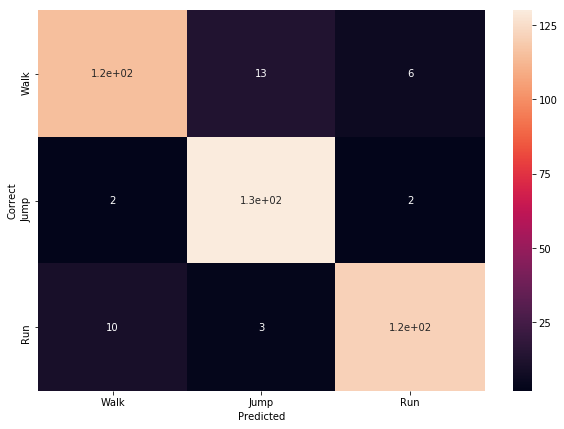

In [0]:
conf_matrix = confusion_matrix(custom_model.get_model())

In [0]:
conf_matrix

array([[125.,   1.,   8.],
       [  7., 126.,   1.],
       [ 11.,   0., 123.]])

In [0]:
def get_model(n_timestamps, n_features, n_classes):
  model = Sequential([
       LSTM(units=100, input_shape=(n_timestamps, n_features), return_sequences=True),
       Dropout(0.5),
       Conv1D(filters=64, kernel_size=9, activation='relu', padding='same'),
       Dropout(0.5),
       Conv1D(filters=16, kernel_size=9, activation='relu', padding='same'),
       Dropout(0.5),
       Flatten(),
       Dense(units=100, activation='relu'),
       Dropout(0.5),
       Dense(units=n_classes, activation='softmax'),
   ])
  model.compile(optimizer=Adam(), metrics=['accuracy'], loss='categorical_crossentropy')
  return model